## Analyze output from mp_train_test_one_trace


In [1]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

In [2]:
conf_name = "TD3_4G_3mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22"


In [3]:
prefix = "../output_mp/rates_delay_loss_"
suffix = ".pickle"

pickle_path = prefix+conf_name+suffix
print(pickle_path)
l_rate = pd.read_pickle(pickle_path)
time_step = int(pickle_path.split("/")[2].split("_")[6])
print(time_step)
REAL_NAME = pickle_path.split("/")[2].split("_")[4] + "_" + pickle_path.split("/")[2].split("_")[5]
print(REAL_NAME)

pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
l_rate_gcc = pd.read_pickle(pickle_path_gcc)
trace_name = l_rate_gcc["trace_name"]
print(trace_name)

# pickle_path_hrcc = f"../apply_model/results_hrcc/rates_delay_loss_hrcc_{REAL_NAME}.pickle"
# l_rate_hrcc = pd.read_pickle(pickle_path_gcc)

../output_mp/rates_delay_loss_TD3_4G_3mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22.pickle
200
4G_3mbps
4G_3mbps


In [4]:
for key in l_rate.keys():
    print(len(l_rate[key]))

10


In [5]:
def make_bandwidth_series(trace_path, step_time):
    #read bandwidth file and create series
    #index timestamps, values bandwidth
    with open(trace_path, "r") as f:
        d = json.load(f)
    df = pd.DataFrame(d["uplink"]["trace_pattern"])
    time = [0] + list(df["duration"].cumsum())
    capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
    s = pd.Series(index=pd.to_datetime(time, unit="ms"), data=capacities)
    capacities = s.resample(f"{step_time}ms").bfill()
    return capacities

In [16]:
# df = pd.DataFrame(data=[l_rate[key][m]["bandwidth_prediction"], l_rate[key][m]["sending_rate"]]).T
# df.columns = ["bandwidth_prediction", "sending_rate"]
# df.plot(figsize=(16,6))
# plt.grid()

Trace: ./traces/4G_3mbps.json


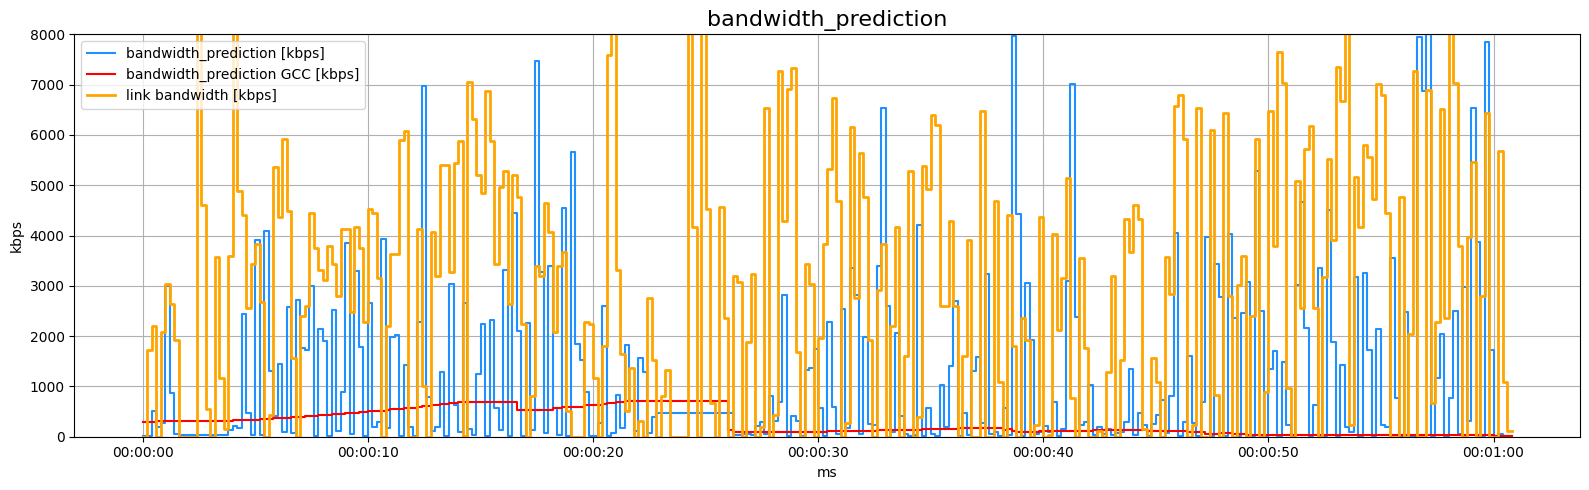

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


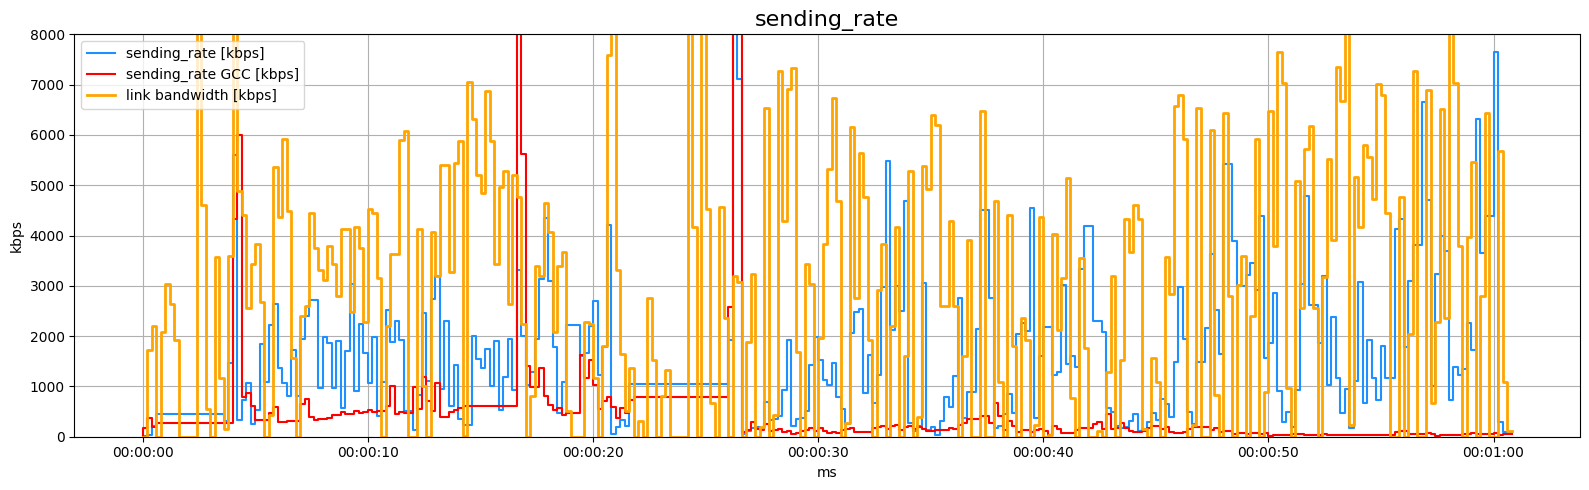

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


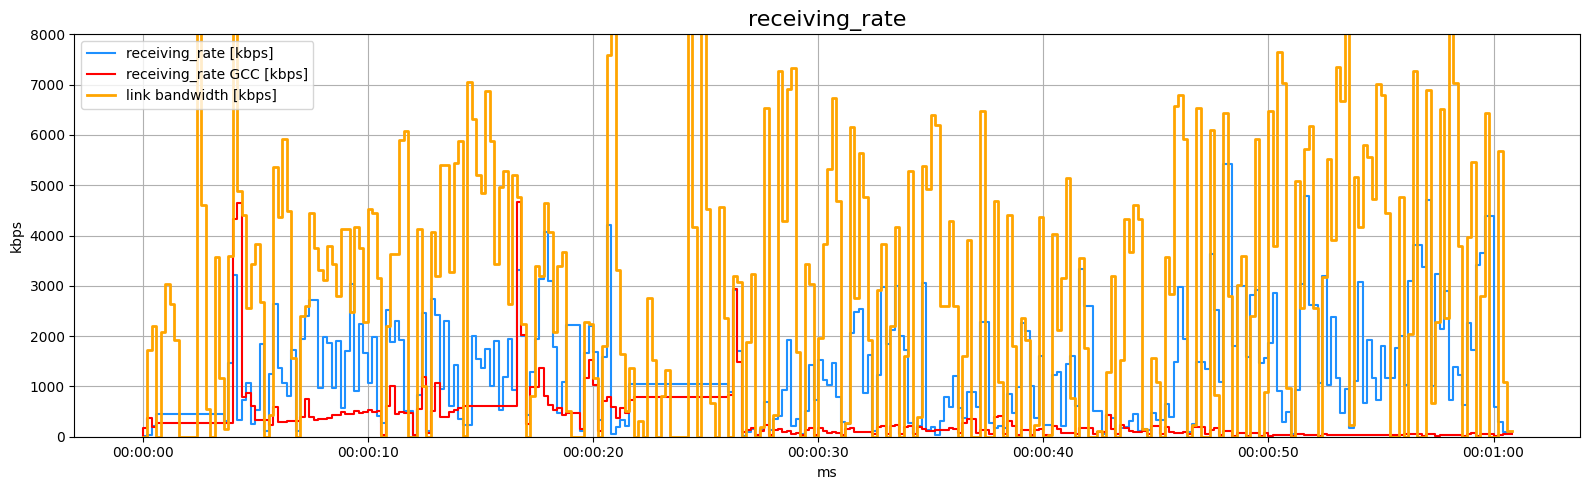

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


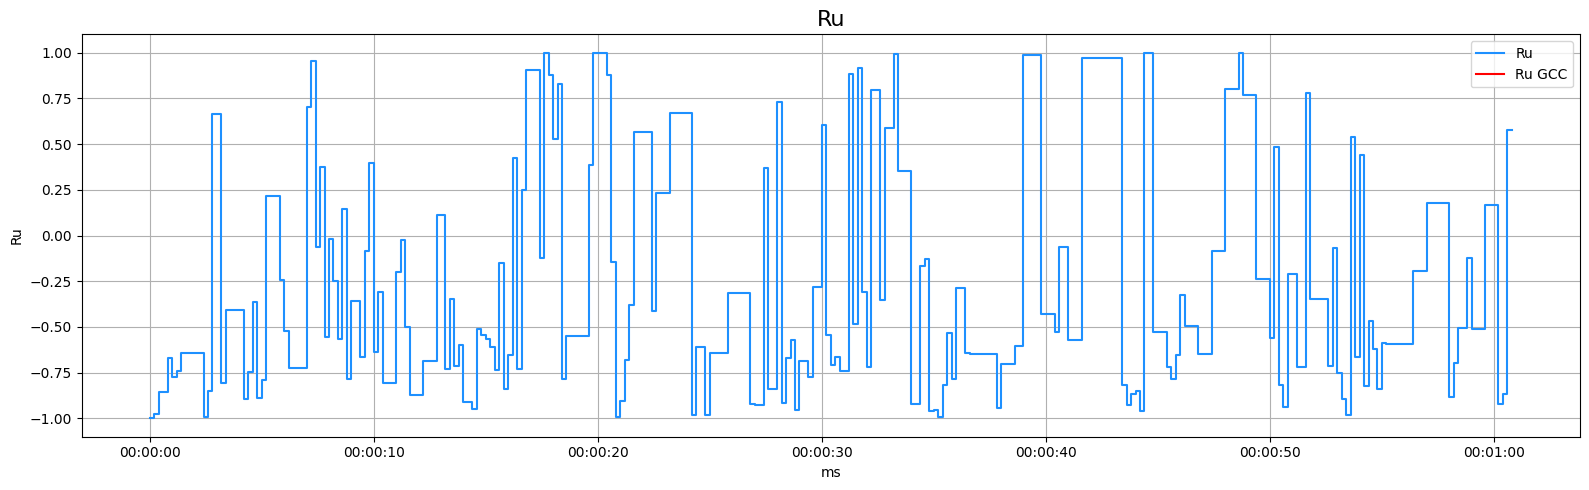

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


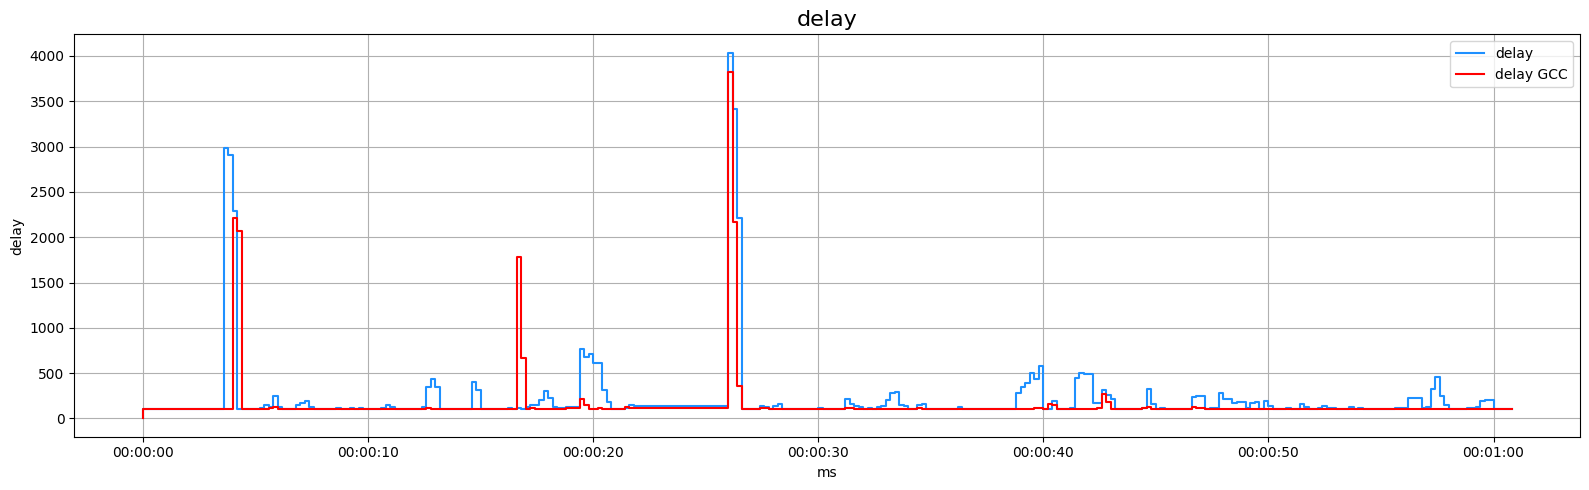

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


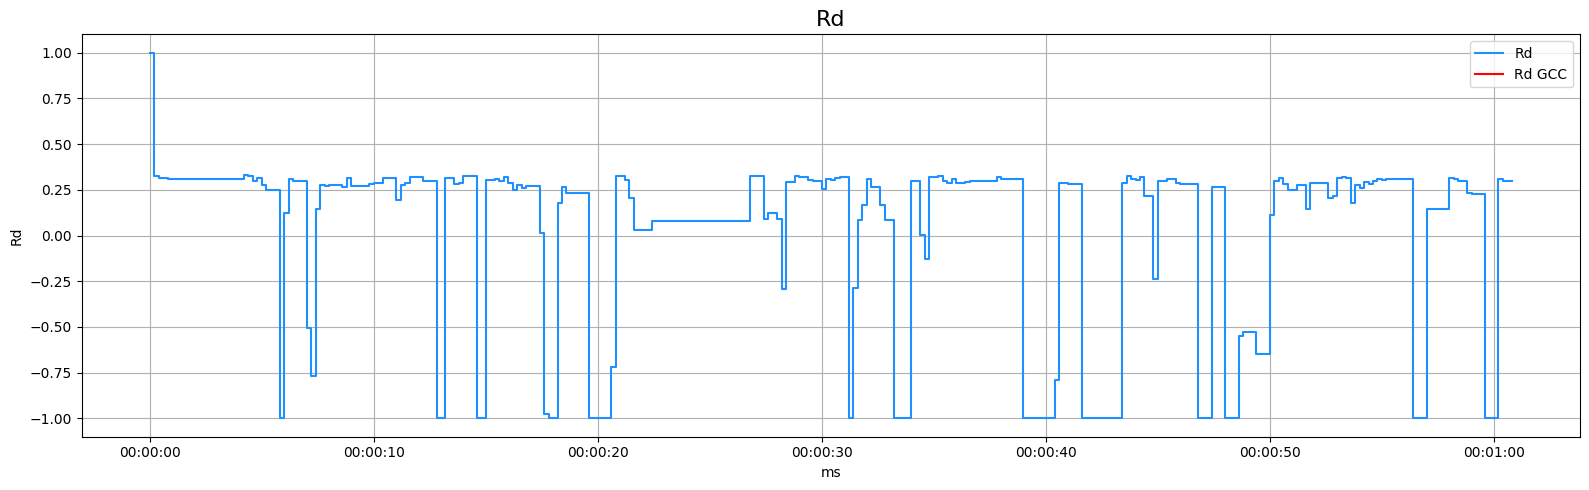

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


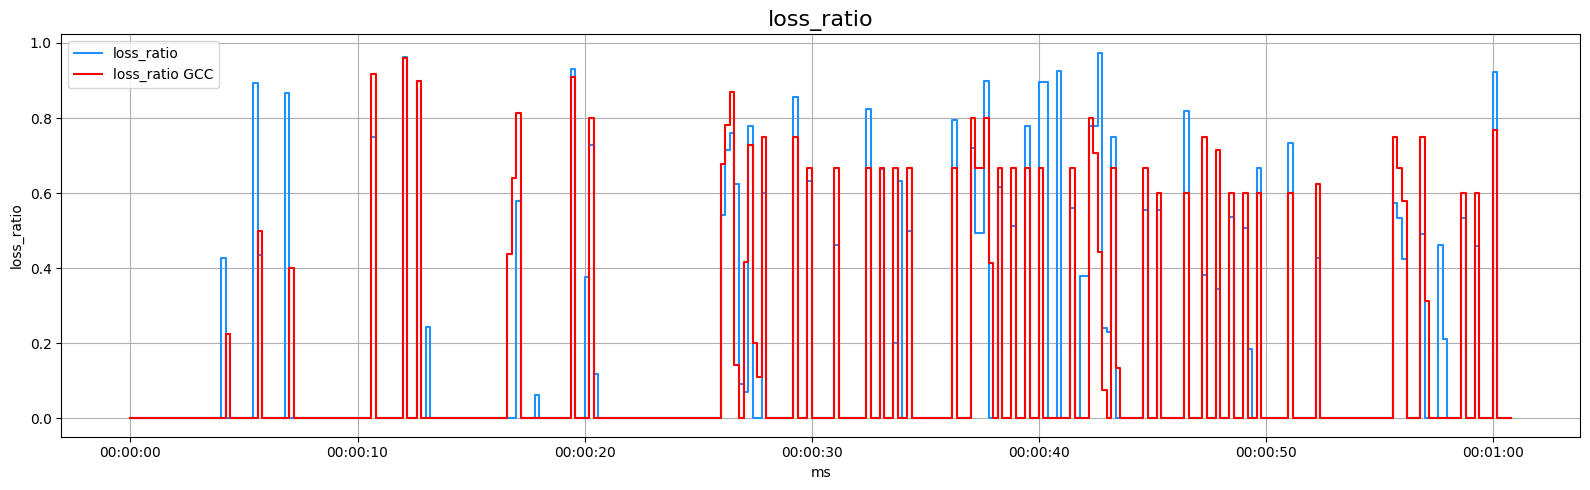

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


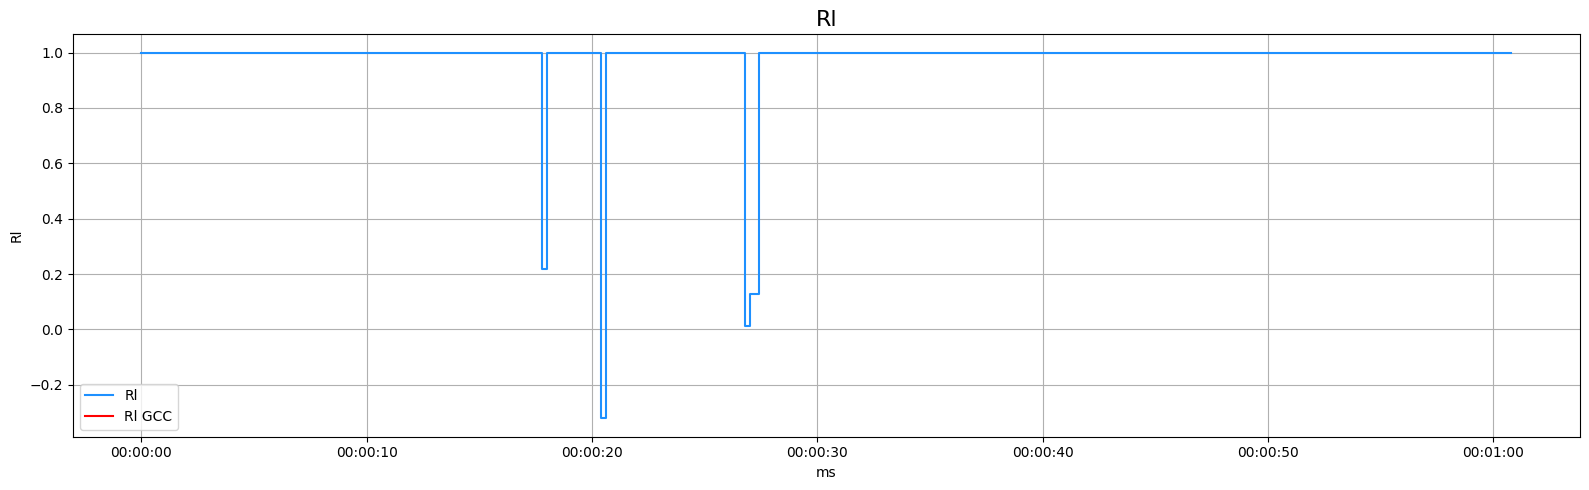

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


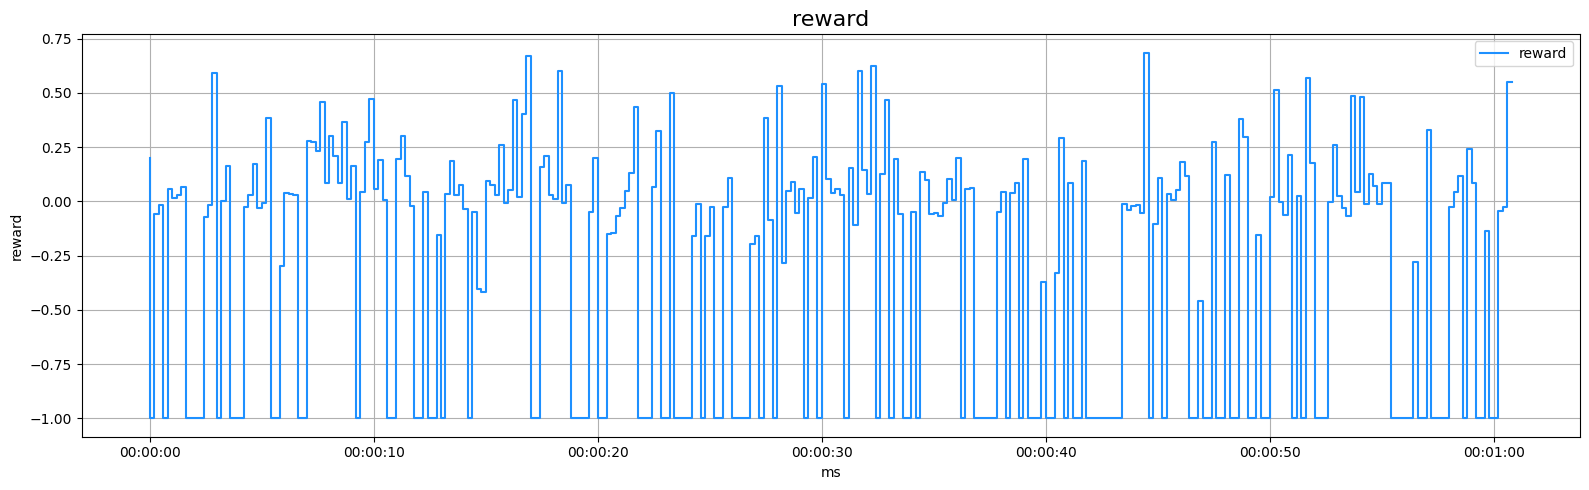

[0.         0.00011574 0.00023148 0.00034722 0.00046296 0.0005787
 0.00069444]


In [6]:
m = 9
plot_gcc = True
plot_hrcc = False

for key in l_rate.keys():
    
    print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["bandwidth_prediction", "sending_rate", "receiving_rate", "Ru", "delay", "Rd", "loss_ratio", "Rl", "reward"]: #reward
        #Define capacity
        
        trace_path = "../" + key.split("/")[1] + "/" + key.split("/")[2]
        capacities = make_bandwidth_series(trace_path, time_step)

        df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
        if plot_gcc and (metric != "reward"):
            df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")
        if plot_hrcc and (metric != "reward"):
            df_rate_hrcc = pd.DataFrame(l_rate_hrcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_hrcc, rsuffix="_hrcc")

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = pd.to_datetime(t, unit="ms")
        df_rate.set_index("time", inplace=True)
        
        df = df_rate.join(pd.DataFrame(capacities, columns=["capacity"]))

        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            fig, ax = plt.subplots(figsize=(16,5))
            plt.title(metric, fontsize=16)
            # color=next(colors)
            plt.step(df.index, df[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df.index, df[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")

            plt.step(df.index, df["capacity"], lw=2, label="link bandwidth [kbps]", color="orange")
            
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            if REAL_NAME == "WIRED_200kbps":
                # plt.xlim(0.00208333,)
                pass
            if REAL_NAME == "WIRED_35mbps":
                plt.ylim((0, 40000))
            elif REAL_NAME == "4G_700kbps":
                plt.ylim(0, 1500)
            elif REAL_NAME == "4G_3mbps":
                plt.ylim(0,8000)
            elif REAL_NAME == "4G_500kbps":
                plt.ylim(0,1600)
            plt.tight_layout()

        else:
            fig, ax = plt.subplots(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df.index, df[metric], label=f"{metric}", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df.index, df[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.legend()
            plt.grid()
            
            # if REAL_NAME == "WIRED_200kbps":
            #     pass
            # if REAL_NAME == "WIRED_35mbps":
            #     plt.ylim((0, 40000))
            # elif REAL_NAME == "4G_700kbps":
            #     plt.ylim(0, 1500)
            # elif REAL_NAME == "4G_3mbps":
            #     plt.ylim(0,8000)
            # elif REAL_NAME == "4G_500kbps":
            #     plt.ylim(0,1600)
            plt.tight_layout()
            
        plt.show()
        print(ax.get_xticks())


# Bandwidth plotted in original time step (as it is in file)

In [10]:
# m = 9
# plot_gcc = True
# plot_hrcc = False

# for key in l_rate.keys():
    
#     print(f"Trace: {key}")
#     colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

#     # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
#     for metric in ["receiving_rate", "delay", "sending_rate", "loss_ratio", "reward"]: #reward
#         #Define capacity

#         trace_name = key
#         trace_name = "../" + trace_name.split("/")[1] + "/" + trace_name.split("/")[2]

#         with open(trace_name, "r") as f:
#             d = json.load(f)

#         df = pd.DataFrame(d["uplink"]["trace_pattern"])
#         time = [0] + list(df["duration"].cumsum())
#         capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
        

#         df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
#         if plot_gcc and (metric != "reward"):
#             df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
#             df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")
#         if plot_hrcc and (metric != "reward"):
#             df_rate_hrcc = pd.DataFrame(l_rate_hrcc[metric], columns=[metric])
#             df_rate = df_rate.join(df_rate_hrcc, rsuffix="_hrcc")

#         t = np.arange(len(df_rate))*time_step
#         df_rate["time"] = t
#         df_rate.set_index("time", inplace=True)

#         if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

#             fig, ax = plt.subplots(figsize=(16,5))
#             plt.title(metric, fontsize=16)
#             # color=next(colors)
#             plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
#             if plot_gcc and (metric != "reward"):
#                 plt.step(df_rate.index, df_rate[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")

#             plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            
#             plt.legend()
#             plt.ylabel("kbps")
#             plt.xlabel("ms")
#             plt.grid()
#             if REAL_NAME == "WIRED_200kbps":
#                 plt.xlim(0, 20000)
#                 pass
#             if REAL_NAME == "WIRED_35mbps":
#                 plt.ylim((0, 40000))
#             elif REAL_NAME == "4G_700kbps":
#                 plt.ylim(0, 1500)
#             elif REAL_NAME == "4G_3mbps":
#                 plt.ylim(0,8000)
#             elif REAL_NAME == "4G_500kbps":
#                 plt.ylim(0,1600)
#             plt.tight_layout()

#         else:
#             fig, ax = plt.subplots(figsize=(16,5))
#             plt.title(metric, fontsize=16)
#             plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color="dodgerblue")
#             if plot_gcc and (metric != "reward"):
#                 plt.step(df_rate.index, df_rate[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
#             plt.ylabel(metric)
#             plt.xlabel("ms")
#             plt.legend()
#             plt.grid()
            
#             if REAL_NAME == "WIRED_200kbps":
#                 pass
#             if REAL_NAME == "WIRED_35mbps":
#                 plt.ylim((0, 40000))
#             elif REAL_NAME == "4G_700kbps":
#                 plt.ylim(0, 1500)
#             elif REAL_NAME == "4G_3mbps":
#                 plt.ylim(0,8000)
#             elif REAL_NAME == "4G_500kbps":
#                 plt.ylim(0,1600)
#             plt.tight_layout()
            
#         plt.show()
        
#         if metric == "receiving_rate":
#             break
